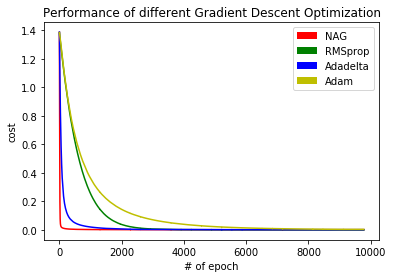

In [1]:
import sys
import numpy as np
import math
import random
import matplotlib
import matplotlib.pylab as plt
from matplotlib.patches import Rectangle


plt_color_array = ['r', 'g', 'b', 'y']
plt_dict = dict()

sigmoid = lambda x: 1.0 / (1.0 + np.exp(-x))
random.seed(1000)

num_feature = 123

opt_algo_set = [ 'NAG', 'RMSprop','Adadelta', 'Adam']


def train(x, y, opt_algo, num_epoch=30, mini_batch=100, lambda_=0.01):
    num_params = 1 * (num_feature + 1) + 2 * 2
    w = np.matrix(0.005 * np.random.random([num_params, 1]))
    data = np.column_stack([x, y])

    gamma = 0.9
    epsilon = 1e-8

    if opt_algo == 'RMSprop' or opt_algo == 'Adam':
        eta = 0.001
    else:
        eta = 0.05

    v = np.matrix(np.zeros(w.shape))
    m = np.matrix(np.zeros(w.shape))

    # Adam params
    beta1 = 0.9
    beta2 = 0.999
    beta1_exp = 1.0
    beta2_exp = 1.0

    # Adagrad params
    grad_sum_square = np.matrix(np.zeros(w.shape))

    # Adadelta & RMSprop params
    grad_expect = np.matrix(np.zeros(w.shape))
    delta_expect = np.matrix(np.zeros(w.shape))

    first_run = True
    for epoch in range(num_epoch):
        np.random.shuffle(data)
        k = 0
        cost_array = list()
        while k < len(data):
            x = data[k: k + mini_batch, 0: -1]
            y = np.matrix(data[k: k + mini_batch, -1], dtype='int32')
            if opt_algo == 'SGD':
                # Stochastic gradient descent
                cost, grad = gradient(x, y, lambda_, w)
                w = w - eta * grad

            elif opt_algo == 'Momentum':
                # Momentum
                cost, grad = gradient(x, y, lambda_, w)
                v = gamma * v + eta * grad
                w = w - v

            elif opt_algo == 'NAG':
                # Nesterov accelerated gradient
                cost, grad = gradient(x, y, lambda_, w - gamma * v)
                v = gamma * v + eta * grad
                w = w - v

            elif opt_algo == 'Adagrad':
                # Adagrad
                cost, grad = gradient(x, y, lambda_, w)
                grad_sum_square += np.square(grad)
                delta = - eta * grad / np.sqrt(grad_sum_square + epsilon)
                w = w + delta

            elif opt_algo == 'Adadelta':
                # Adadelta
                cost, grad = gradient(x, y, lambda_, w)
                grad_expect = gamma * grad_expect + (1.0 - gamma) * np.square(grad)
                # when first run, use sgd
                if first_run == True:
                    delta = - eta * grad
                else:
                    delta = - np.multiply(np.sqrt(delta_expect + epsilon) / np.sqrt(grad_expect + epsilon), grad)
                w = w + delta
                delta_expect = gamma * delta_expect + (1.0 - gamma) * np.square(delta)

            elif opt_algo == 'RMSprop':
                # RMSprop
                cost, grad = gradient(x, y, lambda_, w)
                grad_expect = gamma * grad_expect + (1.0 - gamma) * np.square(grad)
                w = w - eta * grad / np.sqrt(grad_expect + epsilon)

            elif opt_algo == 'Adam':
                # Adam
                cost, grad = gradient(x, y, lambda_, w)
                m = beta1 * m + (1.0 - beta1) * grad
                v = beta2 * v + (1.0 - beta2) * np.square(grad)
                beta1_exp *= beta1
                beta2_exp *= beta2
                w = w - eta * (m / (1.0 - beta1_exp)) / (np.sqrt(v / (1.0 - beta2_exp)) + epsilon)

            k += mini_batch
            cost_array.append(cost)
            if first_run == True: first_run = False

        if not opt_algo in plt_dict:
            plt_dict[opt_algo] = list()
        plt_dict[opt_algo].extend(cost_array)

    return w;


def gradient(x, y, lambda_, w):

    num_sample = len(x)

    w1 = w[0: (num_feature + 1)].reshape(1, num_feature + 1)
    w2 = w[(num_feature + 1):].reshape(2, 2)
    b = np.matrix(np.ones([num_sample, 1]))

    a1 = np.column_stack([x, b])
    s2 = sigmoid(a1 * w1.T)
    a2 = np.column_stack([s2, b])
    a3 = sigmoid(a2 * w2.T)

    y_one_hot = np.matrix(np.zeros([num_sample, 2]))
    y_one_hot[(np.matrix(range(num_sample)), y.T)] = 1

    cost = (1.0 / num_sample) * (
    - np.multiply(y_one_hot, np.log(a3)) - np.multiply(1.0 - y_one_hot, np.log(1.0 - a3))).sum()
    cost += (lambda_ / (2.0 * num_sample)) * (np.square(w1[:, 0: -1]).sum() + np.square(w2[:, 0: -1]).sum())

    delta3 = a3 - y_one_hot
    delta2 = np.multiply(delta3 * w2[:, 0: -1], np.multiply(s2, 1.0 - s2))
    l1_grad = delta2.T * a1
    l2_grad = delta3.T * a2

    r1_grad = np.column_stack([w1[:, 0: -1], np.matrix(np.zeros([1, 1]))])
    r2_grad = np.column_stack([w2[:, 0: -1], np.matrix(np.zeros([2, 1]))])

    w1_grad = (1.0 / num_sample) * l1_grad + (1.0 * lambda_ / num_sample) * r1_grad
    w2_grad = (1.0 / num_sample) * l2_grad + (1.0 * lambda_ / num_sample) * r2_grad
    w_grad = np.row_stack([w1_grad.reshape(-1, 1), w2_grad.reshape(-1, 1)])

    return cost, w_grad


def predict(x,w):
    num_sample = len(x)
    w1 = w[0: (num_feature + 1)].reshape(1, num_feature + 1)
    w2 = w[(num_feature + 1):].reshape(2, 2)
    b = np.matrix(np.ones([num_sample, 1]))
    h1 = sigmoid(np.column_stack([x, b]) * w1.T)
    h2 = sigmoid(np.column_stack([h1, b]) * w2.T)
    return np.argmax(h2, 1)

def test(x, y, w):
    num_sample = len(x)
    y_pred = predict(x,w)
    y_one_hot = (np.zeros(y.shape))
    y_one_hot[np.where(y_pred == y)[0]] = 1
    acc = 1.0 * y_one_hot.sum() / num_sample
    return acc


from sklearn.datasets import load_svmlight_file
data = load_svmlight_file("a9a",query_id=True)
x_train=data[0].todense()
y_train=data[1]
datatest=load_svmlight_file("a9a.t",query_id=True,n_features=123)
x_test=datatest[0].todense()
y_test=datatest[1]

for opt_algo in opt_algo_set:
    w = train(x_train, y_train, opt_algo)
    acc_train = test(x_train, y_train, w)
    acc_test = test(x_test, y_test, w)


plt.subplot(111)
plt.title('Performance of different Gradient Descent Optimization')
plt.xlabel('# of epoch')
plt.ylabel('cost')


proxy = list()
legend_array = list()
for index, (opt_algo, epoch_cost) in enumerate(plt_dict.items()):
    selected_color = plt_color_array[index % len(plt_color_array)]
    plt.plot(range(len(epoch_cost)), epoch_cost, '-%s' % selected_color[0])
    proxy.append(Rectangle((0, 0), 0, 0, facecolor=selected_color))
    legend_array.append(opt_algo)
plt.legend(proxy, legend_array)
plt.show()